In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [20]:
# Flayer setup
f_layer_thickness = 200_000 # m
xfe_outer_core = 1.0 - 0.17 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False

k0 = 150.0
dl = 1.0E-9
k = 100.0
mu = 1.0E-6
i0 = 1.0E-10
surf_energy = 1.08E-2
wetting_angle = 180.0
hetrogeneous_radius = None

In [21]:
def make_layer_plot(dt, dx):

    # Setup the f-layer

    # Derived radii
    r_flayer_top = r_icb + f_layer_thickness
         
    # Discretisation points
    nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
    analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
    knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

    # Reuse general layer setup code, but we don't need many of the functions
    # so we never need to rerun this (fairly expensive) function
    _, adiabatic_temperature_function, _, _, _, pressure_function, gravity_function, _ = layer_setup.setup_flayer_functions(
        r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 10, xfe_outer_core, xfe_outer_core, knott_radii)
    
    temperature_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)+dt, 
            adiabatic_temperature_function(r_flayer_top))
    composition_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, xfe_outer_core+dx, xfe_outer_core)
    Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(
            r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
            composition_function, gravity_function, pressure_function)

    print(f"BV freq = {Nbv}")
    rs = np.linspace(r_icb, r_flayer_top+100.0E3)

    # Check PREM works ... and print some interesting values
    prem = earth_model.Prem()
    print("Pressure at ICB:", prem.pressure(r_icb/1000.0), "GPa")
    print("Pressure at top of F-layer", prem.pressure(r_flayer_top/1000.0), "GPa")
    print("g at ICB:", prem.gravity(r_icb/1000.0), "m/s**2")
    print("g at top of F-layer", prem.gravity(r_flayer_top/1000.0), "m/s**2")

    # Find the liquidus
    tl = feot.find_liquidus(composition_function(rs), pressure_function(rs))

    # Find the liquid density

    liquid_density, _, _, solid_density, _, _ = feot.densities(composition_function(rs), pressure_function(rs),
                                                           temperature_function(rs))

    # This is for a well mixed core extended down 
    adiabatic_liquid_density, _, _, adiabatic_solid_density, _, _ = feot.densities(xfe_outer_core, pressure_function(rs), 
                                                                               adiabatic_temperature_function(rs))
    
    
    print("Liquid density at ICB:", liquid_density[0], "Kg/m^3")
    print("Liquid density at top of F-layer", liquid_density[-1], "Kg/m^3")
    print("Liquid density along adiabat at ICB:", adiabatic_liquid_density[0], "Kg/m^3")
    print("Liquid density along adiabat at top of F-layer", adiabatic_liquid_density[-1], "Kg/m^3")


    # Plot the F-layer setup alongside the liquidus
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(9,9), tight_layout=True)

    color = 'tab:red'
    ax1.set_xlabel('Radius (km)')
    ax1.set_ylabel('Temperature (K)', color=color)
    ax1.plot(rs/1000.0, temperature_function(rs), color=color)
    ax1.plot(rs/1000.0, adiabatic_temperature_function(rs), color=color, ls='--')
    ax1.plot(rs/1000.0, tl, color='k', ls=':')

    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.set_ylim([5900, 6200])
 

    color = 'tab:blue'
    ax2.set_xlabel('Radius (km)')
    ax2.set_ylabel('Pressure (GPs)', color=color)  
    ax2.plot(rs/1000.0, pressure_function(rs), color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([310, 330])

    color = 'tab:green'
    ax3.set_xlabel('Radius (km)')
    ax3.set_ylabel('Composition (mol. frac. Fe)', color=color)  
    ax3.plot(rs/1000.0, composition_function(rs), color=color)
    ax3.tick_params(axis='y', labelcolor=color)

    ax4.set_xlabel('Radius (km)')
    ax4.set_ylabel('Liquid density (kg/m^3)')  
    ax4.plot(rs/1000.0, liquid_density)
    ax4.plot(rs/1000.0, adiabatic_liquid_density, ls='--')
    #ax4.plot(rs/1000.0, solid_density, ls=':')
    ax4.tick_params(axis='y')

    fig.tight_layout()  
    plt.show()

BV freq = 0.0002418266721595237
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Liquid density at ICB: 12796.568981339873 Kg/m^3
Liquid density at top of F-layer 12537.382960401694 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3


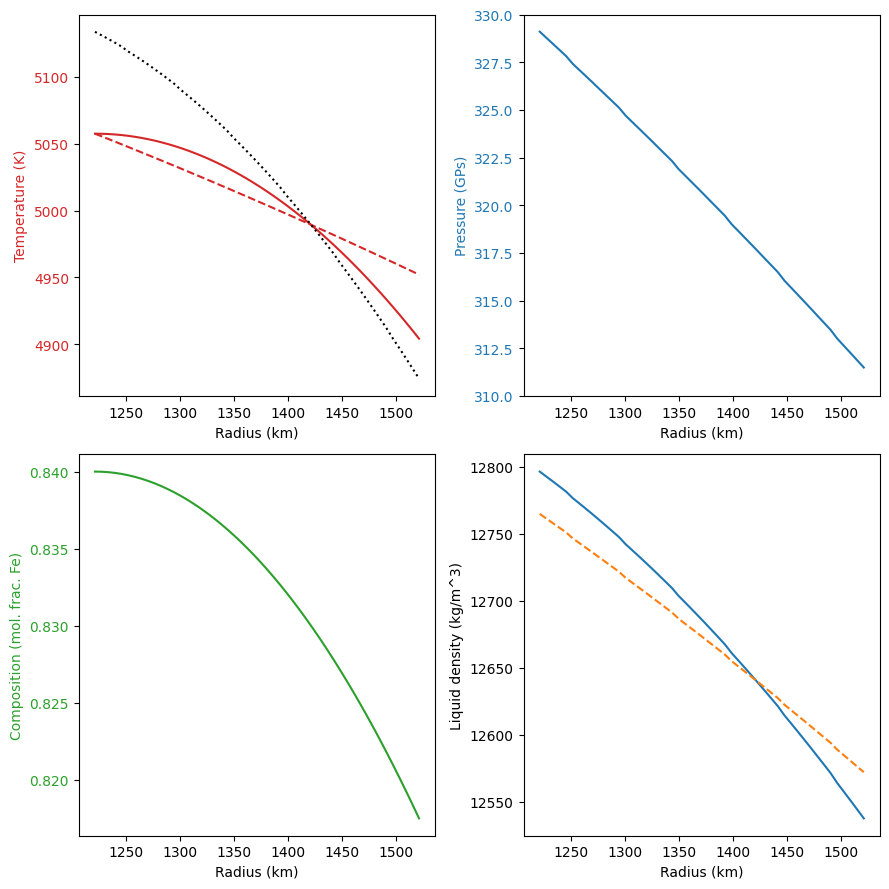

In [23]:
make_layer_plot(0.0, 0.01)